# Malicious URL Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings

In [3]:
df = pd.read_csv('../Datasets/malicious_phish.csv')
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [4]:
df.shape

(651191, 2)

In [5]:
df['type'].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

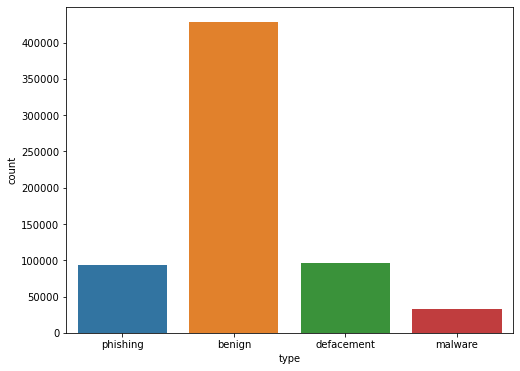

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='type');

## Feature Extraction

In [3]:
import whois
from datetime import datetime, timezone
import math
from pyquery import PyQuery
from requests import get
from interruptingcow import timeout
from tqdm import tqdm

In [5]:
example_url = 'http://www.garage-pirenne.be/index.php?option=com_content&view=article&id=70&vsig70_0=15'

In [6]:
domain = example_url.split('//')[-1].split('/')[0]
domain

'www.garage-pirenne.be'

Testing Whois Library

In [7]:
whois.whois("google.com")

Error trying to connect to socket: closing socket - timed out


{'domain_name': None,
 'registrar': None,
 'whois_server': None,
 'referral_url': None,
 'updated_date': None,
 'creation_date': None,
 'expiration_date': None,
 'name_servers': None,
 'status': None,
 'emails': None,
 'dnssec': None,
 'name': None,
 'org': None,
 'address': None,
 'city': None,
 'state': None,
 'registrant_postal_code': None,
 'country': None}

In [12]:
response = get("https://google.com")
pq = PyQuery(response.text)

In [8]:
class UrlFeaturizer(object):
    def __init__(self, url):
        self.url = url
        self.domain = url.split('//')[-1].split('/')[0]
        self.today = datetime.now().replace(tzinfo=None)

        try:
            self.whois = whois.query(self.domain).__dict__
        except:
            self.whois = None

        try:
            self.response = get(self.url)
            self.pq = PyQuery(self.response.text)
        except:
            self.response = None
            self.pq = None

    def entropy(self):
        string = self.url.strip()
        prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
        entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
        return entropy

    def ip(self):
        string = self.url
        flag = False
        if ("." in string):
            elements_array = string.strip().split(".")
            if(len(elements_array) == 4):
                for i in elements_array:
                    if (i.isnumeric() and int(i)>=0 and int(i)<=255):
                        flag=True
                    else:
                        flag=False
                        break
        if flag:
            return 1 
        else:
            return 0

    def numDigits(self):
        digits = [i for i in self.url if i.isdigit()]
        return len(digits)

    def urlLength(self):
        return len(self.url)

    def numParameters(self):
        params = self.url.split('&')
        return len(params) - 1

    def numFragments(self):
        fragments = self.url.split('#')
        return len(fragments) - 1

    def numSubDomains(self):
        subdomains = self.url.split('http')[-1].split('//')[-1].split('/')
        return len(subdomains)-1

    def domainExtension(self):
        ext = self.url.split('.')[-1].split('/')[0]
        return ext

    ## URL domain features
    def hasHttp(self):
        return 'http:' in self.url

    def hasHttps(self):
        return 'https:' in self.url

    def daysSinceRegistration(self):
        if self.whois and self.whois['creation_date']:
            diff = self.today - self.whois['creation_date'].replace(tzinfo=None)
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0

    def daysSinceExpiration(self):
        if self.whois and self.whois['expiration_date']:
            diff = self.whois['expiration_date'].replace(tzinfo=None) - self.today
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0
    
     ## URL Page Features
    def bodyLength(self):
        if self.pq is not None:
            return len(self.pq('html').text()) if self.urlIsLive else 0
        else:
            return 0

    def numTitles(self):
        if self.pq is not None:
            titles = ['h{}'.format(i) for i in range(7)]
            titles = [self.pq(i).items() for i in titles]
            return len([item for s in titles for item in s])
        else:
            return 0

    def numImages(self):
        if self.pq is not None:
            return len([i for i in self.pq('img').items()])
        else:
            return 0

    def numLinks(self):
        if self.pq is not None:
            return len([i for i in self.pq('a').items()])
        else:
            return 0

    def scriptLength(self):
        if self.pq is not None:
            return len(self.pq('script').text())
        else:
            return 0

    def specialCharacters(self):
        if self.pq is not None:
            bodyText = self.pq('html').text()
            schars = [i for i in bodyText if not i.isdigit() and not i.isalpha()]
            return len(schars)
        else:
            return 0

    def scriptToSpecialCharsRatio(self):
        v = self.specialCharacters()
        if self.pq is not None and v!=0:
            sscr = self.scriptLength()/v
        else:
            sscr = 0
        return sscr

    def scriptTobodyRatio(self):
        v = self.bodyLength()
        if self.pq is not None and v!=0:
            sbr = self.scriptLength()/v
        else:
            sbr = 0
        return sbr

    def bodyToSpecialCharRatio(self):
        v = self.bodyLength()
        if self.pq is not None and v!=0:
            bscr = self.specialCharacters()/v
        else:
            bscr = 0
        return bscr

    def urlIsLive(self):
        return self.response == 200

    def run(self):
        data = {}
        data['entropy'] = self.entropy()
        data['numDigits'] = self.numDigits()
        data['urlLength'] = self.urlLength()
        data['numParams'] = self.numParameters()
        data['hasHttp'] = self.hasHttp()
        data['hasHttps'] = self.hasHttps()
        data['urlIsLive'] = self.urlIsLive()
        data['bodyLength'] = self.bodyLength()
        data['numTitles'] = self.numTitles()
        data['numImages'] = self.numImages()
        data['numLinks'] = self.numLinks()
        data['scriptLength'] = self.scriptLength()
        data['specialChars'] = self.specialCharacters()
        data['ext'] = self.domainExtension()
        data['dsr'] = self.daysSinceRegistration()
        data['dse'] = self.daysSinceExpiration()
        data['sscr'] = self.scriptToSpecialCharsRatio()
        data['sbr'] = self.scriptTobodyRatio()
        data['bscr'] = self.bodyToSpecialCharRatio()
        data['num_%20'] = self.url.count("%20")
        data['num_@'] = self.url.count("@")
        data['has_ip'] = self.ip()
    
        return data

In [9]:
UrlFeaturizer('https://google.com').run()

{'entropy': -3.57243125132212,
 'numDigits': 0,
 'urlLength': 18,
 'numParams': 0,
 'hasHttp': False,
 'hasHttps': True,
 'ext': 'com',
 'num_%20': 0,
 'num_@': 0,
 'has_ip': 0}

In [10]:
warnings.simplefilter(action='ignore', category=FutureWarning)

### Loading the data

In [8]:
df1 = pd.read_csv('../Datasets/feature_extraction.csv')
df2 = pd.read_csv('../Datasets/feature_extraction2.csv')
df3 = pd.read_csv('../Datasets/feature_extraction3.csv')

In [11]:
df1.shape, df2.shape, df3.shape

((280000, 11), (350000, 11), (21189, 11))

In [15]:
df = pd.concat([df1, df2, df3])
df.shape

(651189, 11)

In [16]:
df.head()

,entropy,numDigits,urlLength,numParams,hasHttp,hasHttps,ext,num_%20,num_@,has_ip,target
0,-3.375000,0,16,0,False,False,br,0,0,0,phishing
1,-4.079143,1,35,0,False,False,html,0,0,0,benign
2,-3.708093,1,31,0,False,False,htm,0,0,0,benign
3,-4.660343,7,88,3,True,False,php?option=com_content&view=article&id=70&vsig...,0,0,0,defacement
4,-5.491293,22,235,2,True,False,php?option=com_mailto&tmpl=component&link=aHR0...,0,0,0,defacement


In [17]:
df['target'].value_counts()

benign        428102
defacement     96457
phishing       94110
malware        32520
Name: target, dtype: int64

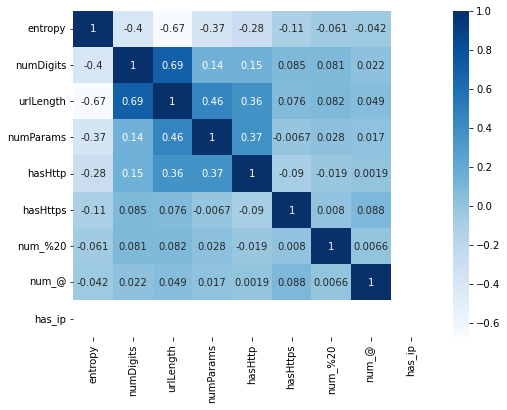

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='Blues');

In [36]:
df.isna().sum()

entropy        0
numDigits      0
urlLength      0
numParams      0
hasHttp        0
hasHttps       0
ext          161
num_%20        0
num_@          0
has_ip         0
target         0
dtype: int64

In [26]:
df['ext']

php?show=759                                                                                    1
exe?id=950942&hash=5                                                                            1
html?cid=rssnewscanada                                                                          1
aspx?search-releases=scott+tucker&x=0&y=0                                                       1
php?option=com_content&view=article&id=180:may-15-teamwork-episode-05&catid=66:teamwork         1
                                                                                            ...  
php                                                                                         21230
htm                                                                                         30358
org                                                                                         32525
html                                                                                        96202
com                 

In [46]:
def clean_ext(ext):
    if(isinstance(ext, str)):
        if '?' in ext:
            return ext.split('?')[0]
        return ext
    else:
        return ""

In [47]:
clean_ext('exe?id=950942&hash=5')

'exe'

In [51]:
df['ext'] = df['ext'].apply(lambda e: clean_ext(e))

In [53]:
df.isna().sum()

entropy      0
numDigits    0
urlLength    0
numParams    0
hasHttp      0
hasHttps     0
ext          0
num_%20      0
num_@        0
has_ip       0
target       0
dtype: int64

In [69]:
df['ext'].value_counts().sort_values(ascending=False)[:400]

com       238259
html      107692
php        77677
org        32526
htm        32270
           ...  
paypal        17
mu            16
wz            16
today         16
35            16
Name: ext, Length: 400, dtype: int64

### References:
https://medium.com/nerd-for-tech/url-feature-engineering-and-classification-66c0512fb34d